# Assignment 2

SID: 12110613  
Name: 任嘉熙

----

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from h3 import h3
import folium
import branca.colormap as cm

In [2]:
offers=pd.read_csv('datasets/data_offers.csv')
orders=pd.read_csv('datasets/data_orders.csv')

In [3]:
offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [4]:
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


## Q1

In [5]:
group_counts=orders.groupby(["order_status_key","is_driver_assigned_key"]).size().reset_index(name='Number')

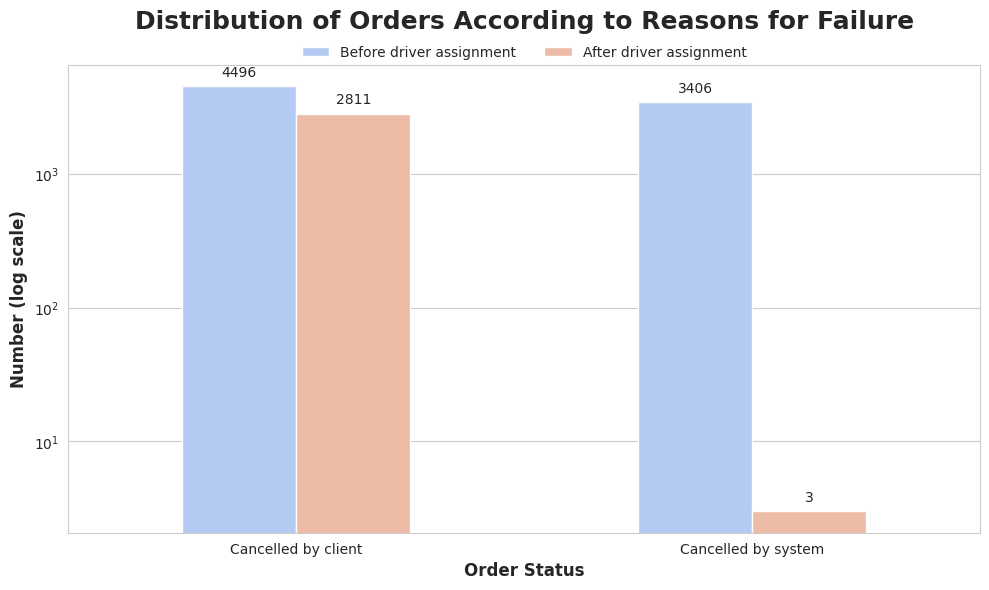

In [6]:
sns.set_style("whitegrid")
sns.set_palette("pastel")

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x='order_status_key', y='Number', hue='is_driver_assigned_key', data=group_counts, palette='coolwarm', ax=ax, width=0.5)

# ax.grid(True)

plt.title('Distribution of Orders According to Reasons for Failure', fontsize=18, fontweight='bold', y=1.06)
plt.xlabel('Order Status', fontsize=12, fontweight='bold')
plt.ylabel('Number (log scale)', fontsize=12, fontweight='bold')

plt.xticks(range(2),["Cancelled by client","Cancelled by system"], fontsize=10)

ax.set_yscale('log')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    if height == 0:  # Skip the bar with height 0
        continue
    ax.annotate(format(height, '.0f'), 
                (p.get_x() + p.get_width() / 2., height), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

legend = plt.legend(bbox_to_anchor=(0.5, 1.0), loc='lower center', borderaxespad=0., ncol=2, frameon=False)
new_labels = ["Before driver assignment", "After driver assignment"]
for t, l in zip(legend.texts, new_labels): t.set_text(l)
# legend.set_title("Driver Assignment Status", prop={'size': 12, 'weight': 'bold'})

plt.tight_layout()
plt.show()

In this plot I choose to use bar plot and use different colors to represent if the driver is assigned or not. After plot the figure in origin scale, I found that the number of orders cancelled by system after driver assignment is much smaller than others (just 3), and it can't be directly seen on the plot. As a consequence I choose to use log scale to plot the figure again and assign the number of orders according to different reasons for failure. The result shows that the order cancelled by client before driver assignment is the most common reason for failure with number 4496.

## Q2

First we should calculate the numbers of orders according to different failed reasons by hours.

In [7]:
orders["order_datetime"] = pd.to_datetime(orders["order_datetime"])
orders["order_hour"] = orders["order_datetime"].dt.hour
def failure_reason(row):
    if (row["order_status_key"] == 4) & (row["is_driver_assigned_key"] == 0):
        return "Cancelled by client\nbefore driver assignment"
    elif (row["order_status_key"] == 4) & (row["is_driver_assigned_key"] == 1):
        return "Cancelled by client\nafter driver assignment"
    elif (row["order_status_key"] == 9) & (row["is_driver_assigned_key"] == 0):
        return "Cancelled by system\nbefore driver assignment"
    else:
        return "Cancelled by system\nafter driver assignment"
orders["failure_reason"] = orders.apply(failure_reason, axis=1)
failure_count = orders.pivot_table(index='order_hour', columns='failure_reason', aggfunc='size', fill_value=0).reset_index().rename_axis(None, axis=1)
failure_count['total_orders'] = failure_count[['Cancelled by client\nbefore driver assignment', 'Cancelled by client\nafter driver assignment', 'Cancelled by system\nbefore driver assignment', 'Cancelled by system\nafter driver assignment']].sum(axis=1)

failure_count.head(5)

,order_hour,Cancelled by client\nafter driver assignment,Cancelled by client\nbefore driver assignment,Cancelled by system\nafter driver assignment,Cancelled by system\nbefore driver assignment,total_orders
0,0,120,298,2,263,683
1,1,88,219,0,164,471
2,2,78,237,0,240,555
3,3,64,224,0,225,513
4,4,41,50,0,61,152


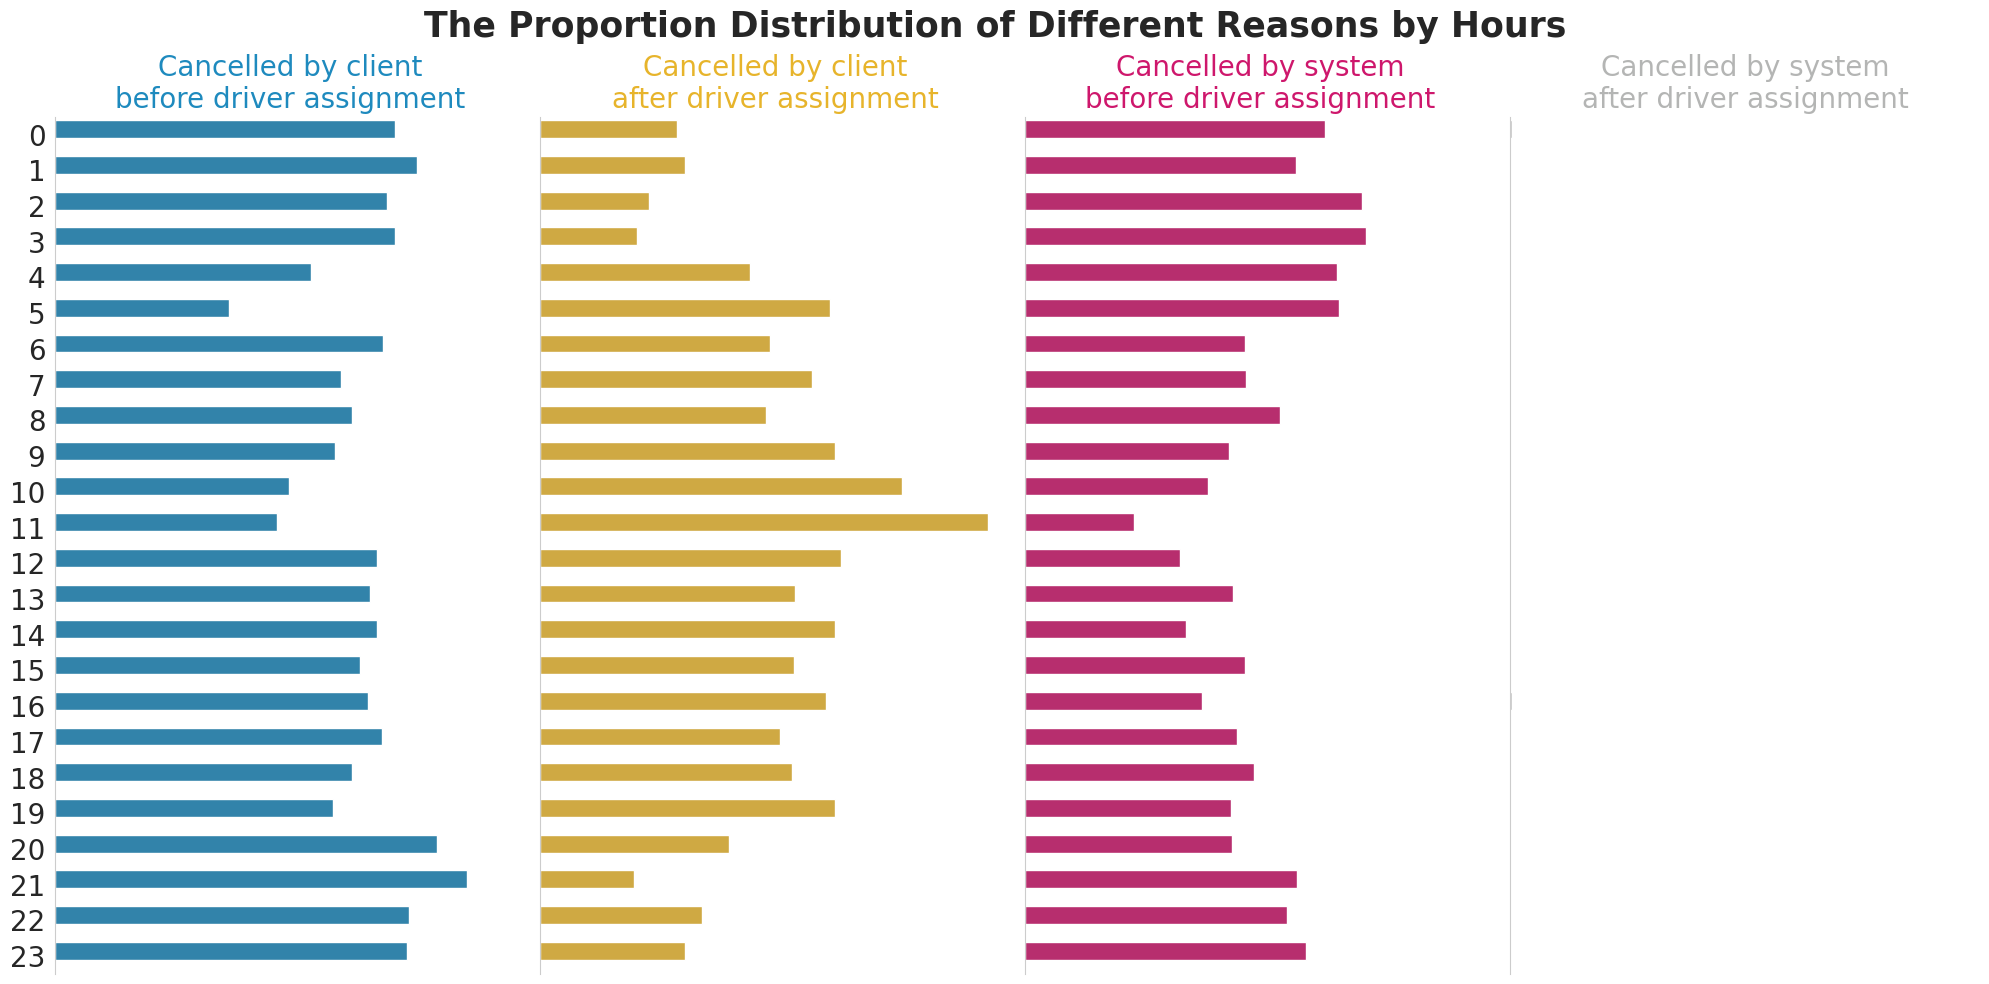

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(20,10), sharey=True, sharex=True)

colors=["#1E8ABE","#E7B42B","#CE176C","#B4B5B4"]
columns=["Cancelled by client\nbefore driver assignment","Cancelled by client\nafter driver assignment","Cancelled by system\nbefore driver assignment","Cancelled by system\nafter driver assignment"]

for i, ax in enumerate(axs):
    sns.barplot(x=failure_count[columns[i]]/failure_count["total_orders"], y=failure_count['order_hour'].astype(str), ax=ax, color=colors[i], height=0.5)
    ax.set_title(columns[i], color=colors[i], fontsize=20)
   
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.spines['left'].set_visible(True)
  
    ax.set_xticks([])
 
    ax.tick_params(axis='y', labelsize=20)
    ax.set_xlabel('')
    ax.set_ylabel('')

title_text = "The Proportion Distribution of Different Reasons by Hours"
fig.suptitle(title_text, fontsize=25, weight='bold')
plt.tight_layout()
plt.show()

From the plot, we can see that at 11 a.m. the proportion of orders cancelled by client after driver assignment is abnormally high, and there is a trend that before 11 a.m. the proportion of orders cancelled by client before driver assignment is getting higher, and after that the proportion is getting lower.

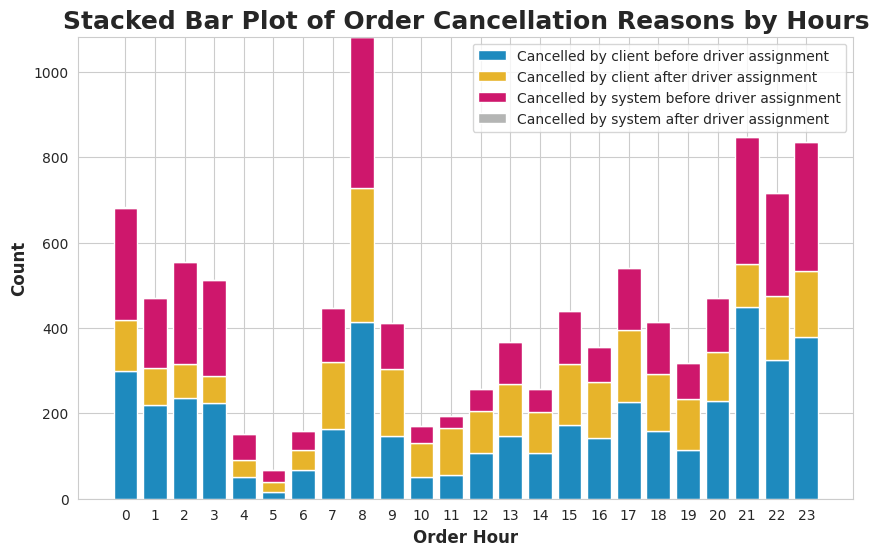

In [9]:
fig, ax = plt.subplots(figsize=(10,6))

bars = np.add(failure_count['Cancelled by client\nbefore driver assignment'], failure_count['Cancelled by client\nafter driver assignment']).tolist()
ax.bar(failure_count['order_hour'], failure_count['Cancelled by client\nbefore driver assignment'], color="#1E8ABE", label='Cancelled by client before driver assignment')
ax.bar(failure_count['order_hour'], failure_count['Cancelled by client\nafter driver assignment'], bottom=failure_count['Cancelled by client\nbefore driver assignment'], color="#E7B42B", label='Cancelled by client after driver assignment')

ax.bar(failure_count['order_hour'], failure_count['Cancelled by system\nbefore driver assignment'], bottom=bars, color="#CE176C", label='Cancelled by system before driver assignment')
bars = np.add(bars, failure_count['Cancelled by system\nbefore driver assignment']).tolist()

ax.bar(failure_count['order_hour'], failure_count['Cancelled by system\nafter driver assignment'], bottom=bars, color="#B4B5B4", label='Cancelled by system after driver assignment')

ax.set_xlabel('Order Hour', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Stacked Bar Plot of Order Cancellation Reasons by Hours',fontsize=18, fontweight='bold')
ax.set_xticks(range(24))
ax.legend()

plt.show()

At 8 a.m. the fails get the biggest, the reason I think is that eight o'clock in the morning is the morning rush hour, and at this time people tend not to want to wait and want to call a car immediately, so there will be a lot of order cancellations. They will cancel the currently waiting orders and open new orders.

## Q3

First I filter out any outliers in the column 'cancellations_time_in_seconds'. I choose to filter any outliers in every hour, using 1.5 IQR discriminant rule.

In [10]:
def remove_outliers(group):
    Q1 = group['cancellations_time_in_seconds'].quantile(0.25)
    Q3 = group['cancellations_time_in_seconds'].quantile(0.75)
    IQR = Q3 - Q1
    filter = (group['cancellations_time_in_seconds'] >= Q1 - 1.5 * IQR) & (group['cancellations_time_in_seconds'] <= Q3 + 1.5 * IQR)
    return group.loc[filter]

orders_clean = orders.groupby('is_driver_assigned_key').apply(remove_outliers).reset_index(drop=True)


After filtering, we can do the average time calculation according to if the driver is assigned by hours.

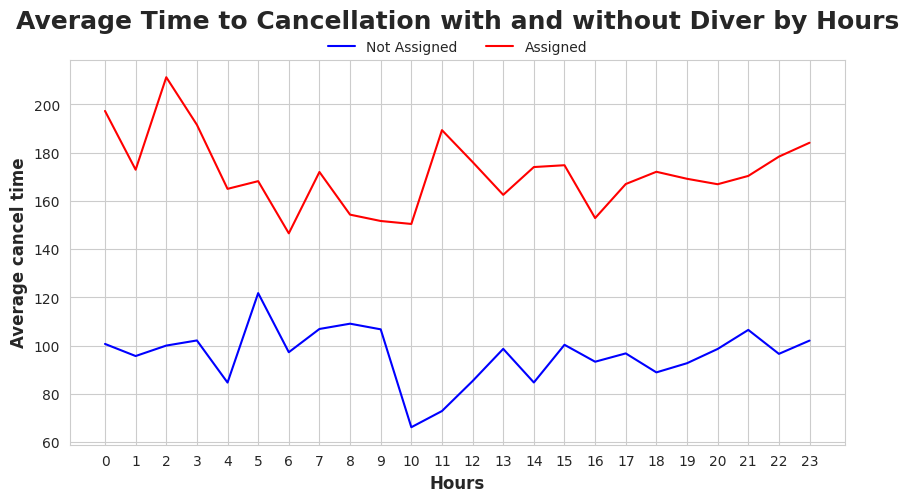

In [11]:
average_cancel_time = orders_clean.groupby(['is_driver_assigned_key', 'order_hour'])['cancellations_time_in_seconds'].mean().reset_index()
pivot_average = average_cancel_time.pivot(index='order_hour', columns='is_driver_assigned_key', values='cancellations_time_in_seconds')
pivot_average.columns = ['Not Assigned', 'Assigned']
plt.figure(figsize=(10,5))
sns.lineplot(data=pivot_average, palette=['blue', 'red'], dashes=False)
plt.title('Average Time to Cancellation with and without Diver by Hours', fontsize=18, fontweight='bold', y=1.06)
plt.xlabel('Hours', fontsize=12, fontweight='bold')
plt.ylabel('Average cancel time', fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(0.5, 1.0), loc='lower center', borderaxespad=0., ncol=2, frameon=False)
plt.xticks(range(0, 24))
plt.show()

In general, the average time of cancellation when no driver is assigned is much less than when a driver is assigned. It is also very common sense at this point. When a driver has been assigned, people tend to wait more patiently. At 10 o'clock people tend to wait inpatiently maybe because at this time he or she has been late for work.

## Q4

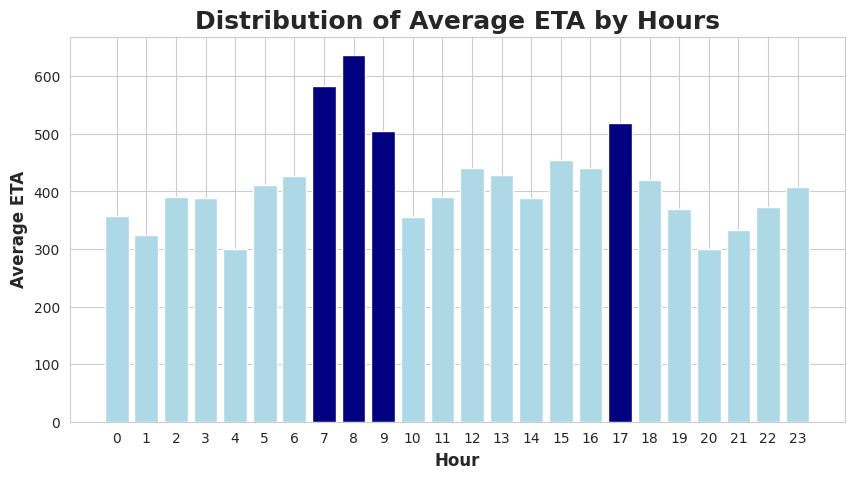

In [12]:
orders_nona = orders.dropna(subset=["m_order_eta"])
average_eta_by_hour = orders_nona.groupby('order_hour')['m_order_eta'].mean().reset_index()
top_hours = average_eta_by_hour.nlargest(4, 'm_order_eta')['order_hour']
colors = ['navy' if hour in top_hours.values else 'lightblue' for hour in average_eta_by_hour['order_hour']]

plt.figure(figsize=(10,5))
plt.bar(average_eta_by_hour['order_hour'], average_eta_by_hour['m_order_eta'], color=colors)
plt.title('Distribution of Average ETA by Hours', fontsize=18, fontweight='bold')
plt.xlabel('Hour', fontsize=12, fontweight='bold')
plt.ylabel('Average ETA', fontsize=12, fontweight='bold')
plt.xticks(range(0, 24))
plt.show()


Generally speaking, I pick the 4 highest average ETA, which is at 7, 8, 9, 17 o'clock. During these times, which are the morning peak and evening peak times, due to traffic jams and an increase in order volume, the time it takes for drivers to take orders and pick up passengers will also be longer.

## Q5

In this problem I searched from the hexagon with the largest number of orders to the smallest, when the cumulated orders arrived 80% of all orders the searching can be stopped. There are 24 hexes in total.

In [13]:
orders['h3_index'] = orders.apply(lambda row: h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], 8), axis=1)

fail_counts = orders['h3_index'].value_counts().reset_index()
fail_counts.columns = ['h3_index', 'fail_count']

fail_counts = fail_counts.sort_values(by='fail_count', ascending=False)
fail_counts['cumulative_count'] = fail_counts['fail_count'].cumsum()
total_fails = fail_counts['fail_count'].sum()
fail_counts['cumulative_percent'] = 100 * fail_counts['cumulative_count'] / total_fails

over_80_index = fail_counts[fail_counts['cumulative_percent'] > 80].index[0]

hexes_80_percent = fail_counts.loc[:over_80_index, 'h3_index']

min_fail = fail_counts['fail_count'].min()
max_fail = fail_counts['fail_count'].max()
colormap = cm.LinearColormap(colors=['lightblue', 'darkblue'], vmin=min_fail, vmax=max_fail)

m = folium.Map(location=[orders['origin_latitude'].mean(), orders['origin_longitude'].mean()], zoom_start=13)

for index, row in fail_counts.iterrows():
    if row['h3_index'] in hexes_80_percent.values:
        hex_boundary = h3.h3_to_geo_boundary(row['h3_index'])
        color = colormap(row['fail_count'])
        folium.Polygon(locations=hex_boundary, color=color, fill=True, fill_color=color, fill_opacity=0.7).add_to(m)

colormap.add_to(m)

m